In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
import opendatasets as od
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shintamaliaa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data


100%|██████████| 22.0k/22.0k [00:00<00:00, 18.4MB/s]

In [ ]:
train_df = pd.read_csv("/content/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("/content/daily-climate-time-series-data/DailyDelhiClimateTest.csv")

In [ ]:
train_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
test_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [ ]:
num_rec_train = train_df.shape[0]
print(f'Train dataframe contains {num_rec_train} records belongings to {num_rec_train} days or {round(num_rec_train/30,1)} months or {round(num_rec_train/365,1)} years')

num_rec_test = test_df.shape[0]
print(f'Test dataframe contains {num_rec_test} records belongings to {num_rec_test} days or {round(num_rec_test/30,1)} months or {round(num_rec_test/365,1)} years')

Train dataframe contains 1462 records belongings to 1462 days or 48.7 months or 4.0 years
Test dataframe contains 114 records belongings to 114 days or 3.8 months or 0.3 years


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          114 non-null    datetime64[ns]
 1   meantemp      114 non-null    float64       
 2   humidity      114 non-null    float64       
 3   wind_speed    114 non-null    float64       
 4   meanpressure  114 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.6 KB


In [ ]:
print("Missing value train: ")
print(train_df.isna().sum())

print("Missing value test: ")
print(test_df.isna().sum())

Missing value train: 
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64
Missing value test: 
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [ ]:
train_df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
print("Jumlah duplikasi: ", train_df.duplicated().sum())
print("Jumlah duplikasi: ", test_df.duplicated().sum())

Jumlah duplikasi:  0
Jumlah duplikasi:  0


In [ ]:
# Set 'date' as index
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

# Resampling Data Mingguan dan Bulanan untuk Data Latih (train_df)
train_df_weekly = train_df.resample('W').mean()  # Weekly mean
train_df_monthly = train_df.resample('M').mean()  # Monthly mean

# Resampling Data Mingguan dan Bulanan untuk Data Uji (test_df)
test_df_weekly = test_df.resample('W').mean()  # Weekly mean
test_df_monthly = test_df.resample('M').mean()  # Monthly mean


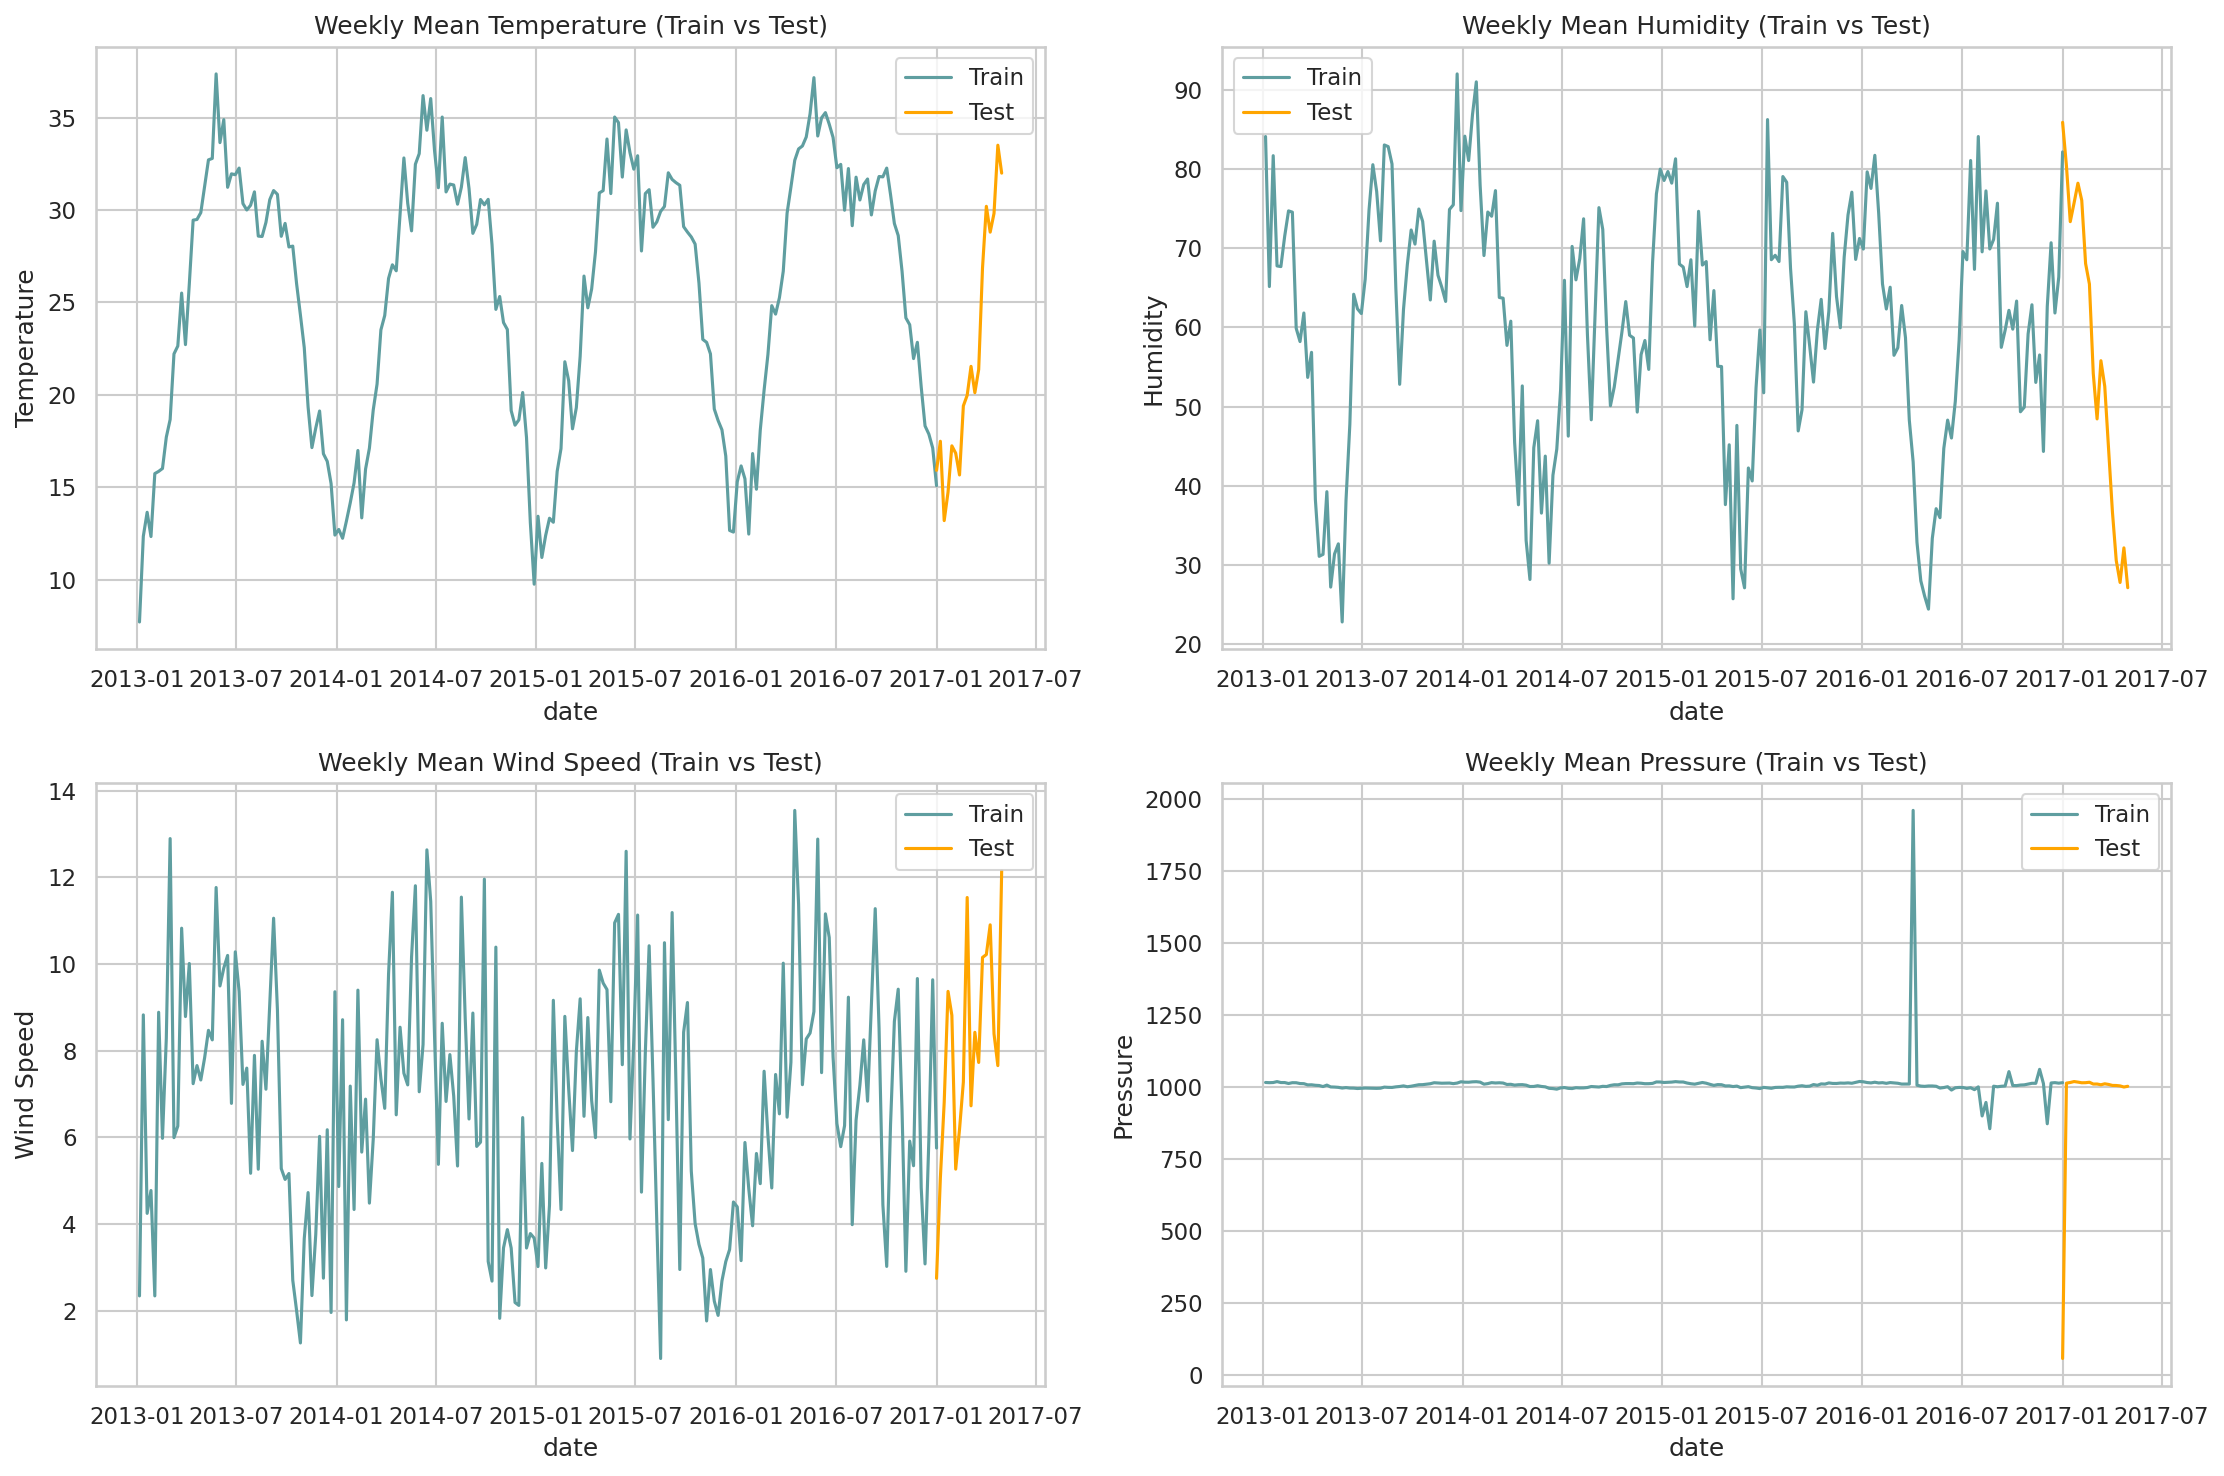

In [ ]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Weekly Mean Temperature (meantemp)
sns.lineplot(data=train_df_weekly['meantemp'], ax=axes[0, 0], color='cadetblue', label='Train')
sns.lineplot(data=test_df_weekly['meantemp'], ax=axes[0, 0], color='orange', label='Test')
axes[0, 0].set_title('Weekly Mean Temperature (Train vs Test)')
axes[0, 0].set_ylabel('Temperature')

# Plotting Weekly Mean Humidity (humidity)
sns.lineplot(data=train_df_weekly['humidity'], ax=axes[0, 1], color='cadetblue', label='Train')
sns.lineplot(data=test_df_weekly['humidity'], ax=axes[0, 1], color='orange', label='Test')
axes[0, 1].set_title('Weekly Mean Humidity (Train vs Test)')
axes[0, 1].set_ylabel('Humidity')

# Plotting Weekly Mean Wind Speed (wind_speed)
sns.lineplot(data=train_df_weekly['wind_speed'], ax=axes[1, 0], color='cadetblue', label='Train')
sns.lineplot(data=test_df_weekly['wind_speed'], ax=axes[1, 0], color='orange', label='Test')
axes[1, 0].set_title('Weekly Mean Wind Speed (Train vs Test)')
axes[1, 0].set_ylabel('Wind Speed')

# Plotting Weekly Mean Pressure (meanpressure)
sns.lineplot(data=train_df_weekly['meanpressure'], ax=axes[1, 1], color='cadetblue', label='Train')
sns.lineplot(data=test_df_weekly['meanpressure'], ax=axes[1, 1], color='orange', label='Test')
axes[1, 1].set_title('Weekly Mean Pressure (Train vs Test)')
axes[1, 1].set_ylabel('Pressure')

# Mengatur layout agar tidak saling bertumpuk
plt.tight_layout()
plt.show()

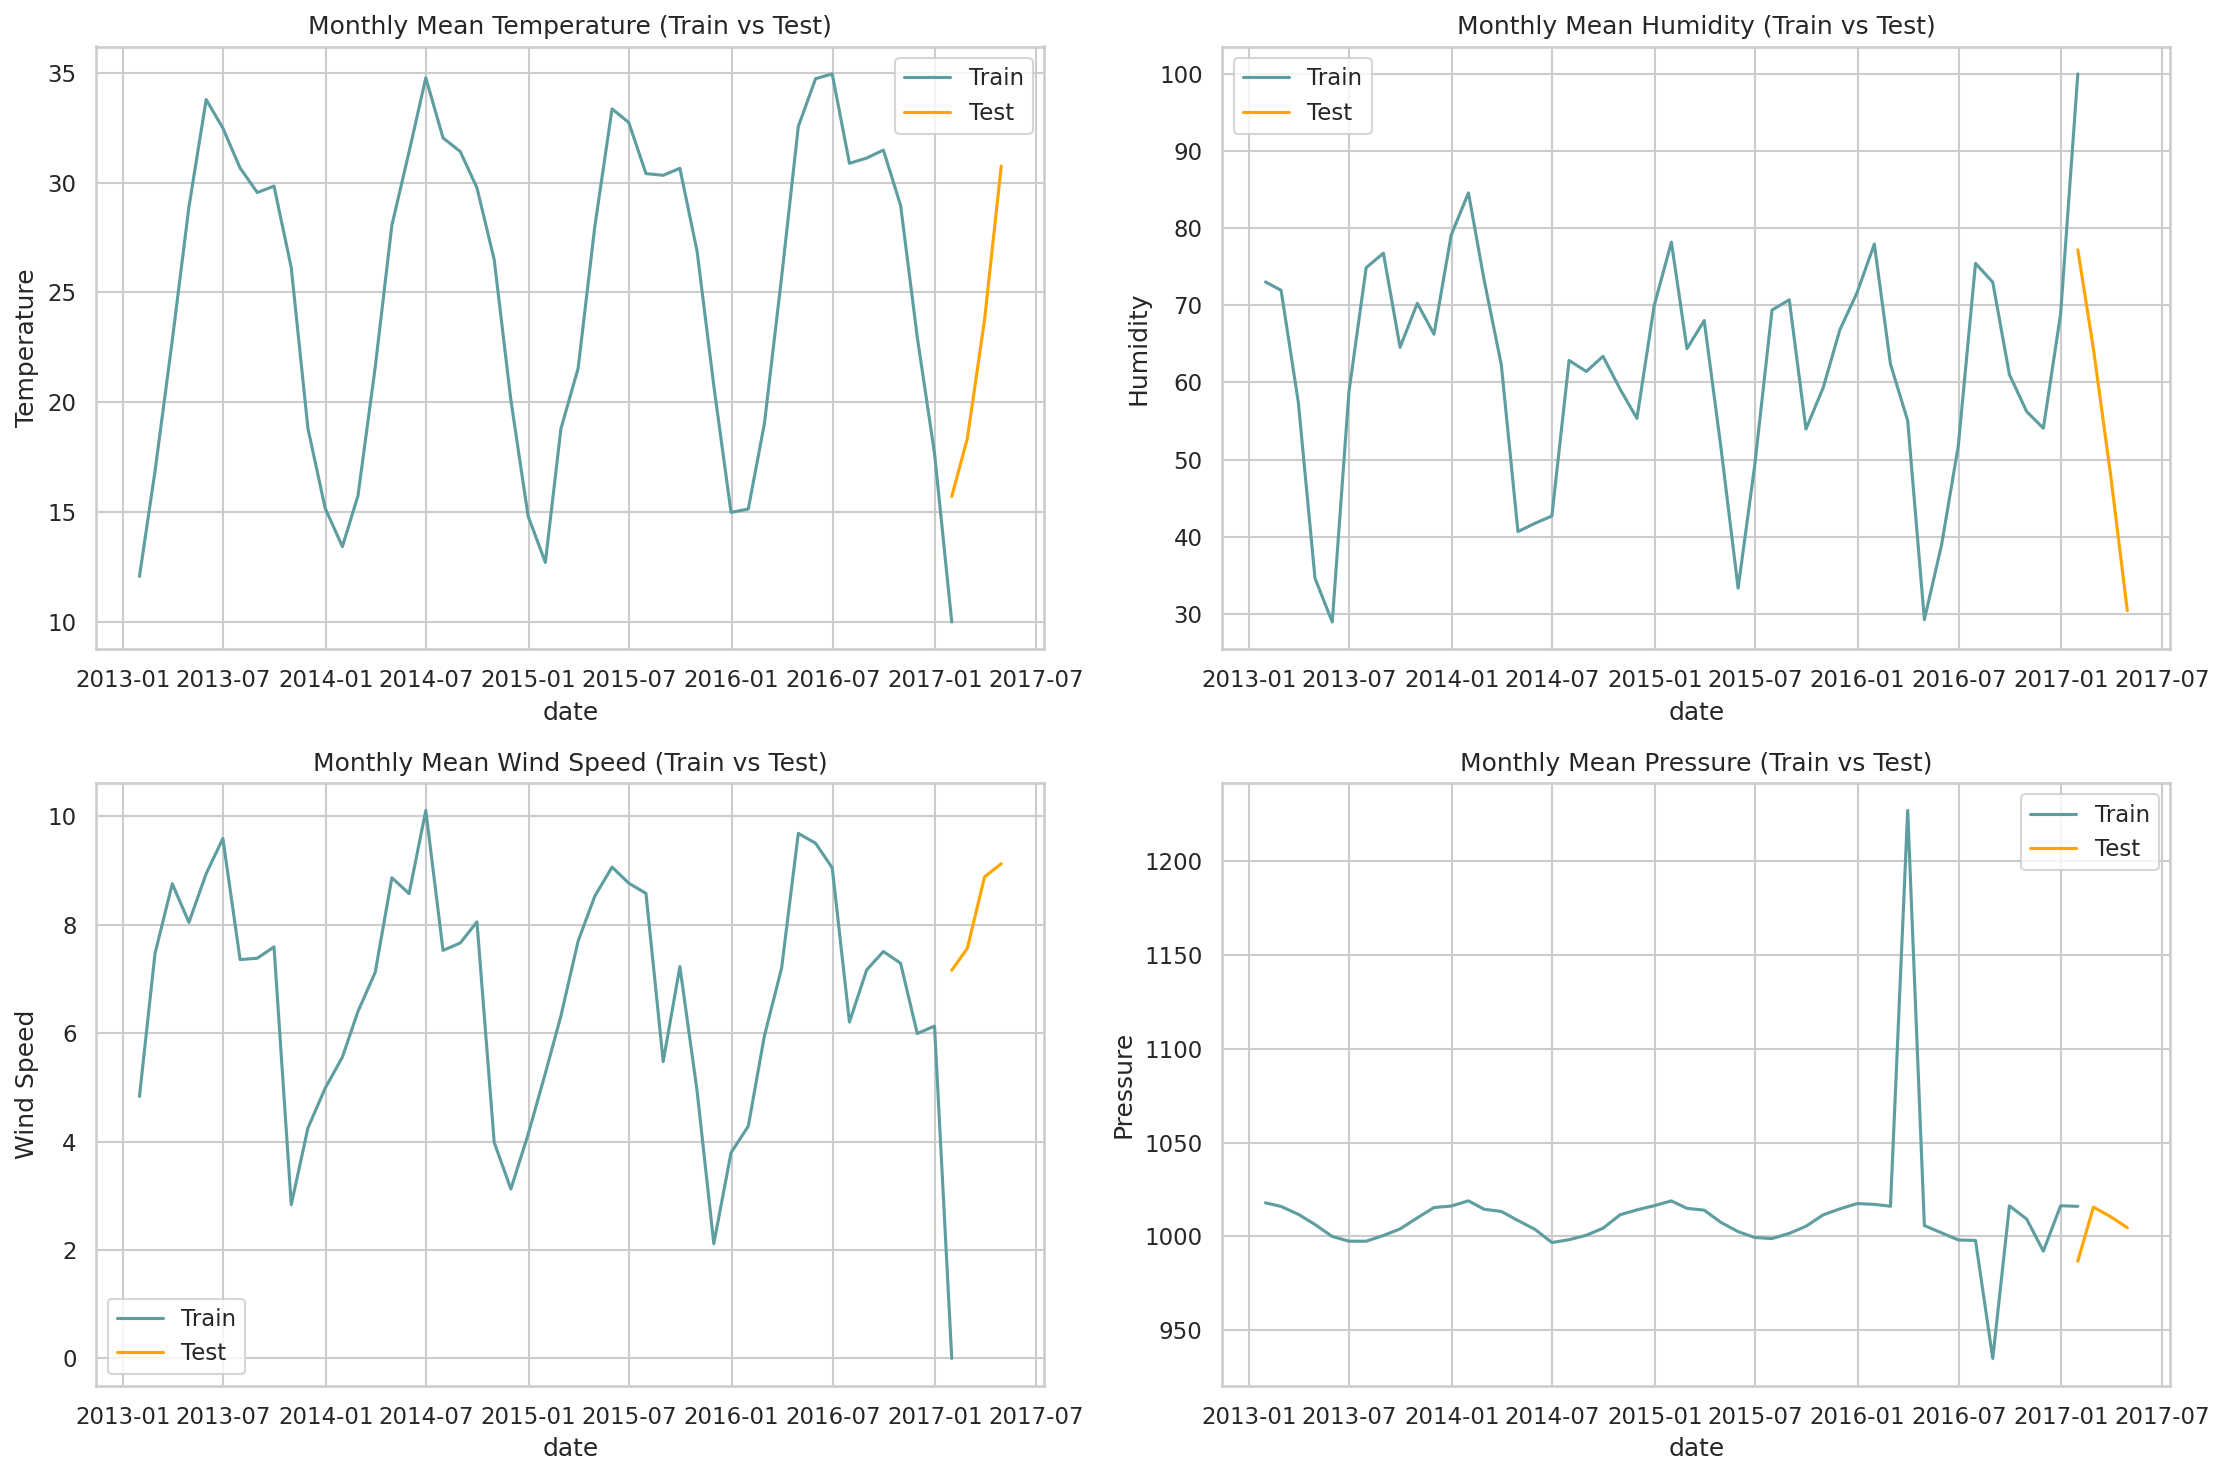

In [ ]:
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Monthly Mean Temperature (meantemp)
sns.lineplot(data=train_df_monthly['meantemp'], ax=axes[0, 0], color='cadetblue', label='Train')
sns.lineplot(data=test_df_monthly['meantemp'], ax=axes[0, 0], color='orange', label='Test')
axes[0, 0].set_title('Monthly Mean Temperature (Train vs Test)')
axes[0, 0].set_ylabel('Temperature')

# Plotting Monthly Mean Humidity (humidity)
sns.lineplot(data=train_df_monthly['humidity'], ax=axes[0, 1], color='cadetblue', label='Train')
sns.lineplot(data=test_df_monthly['humidity'], ax=axes[0, 1], color='orange', label='Test')
axes[0, 1].set_title('Monthly Mean Humidity (Train vs Test)')
axes[0, 1].set_ylabel('Humidity')

# Plotting Monthly Mean Wind Speed (wind_speed)
sns.lineplot(data=train_df_monthly['wind_speed'], ax=axes[1, 0], color='cadetblue', label='Train')
sns.lineplot(data=test_df_monthly['wind_speed'], ax=axes[1, 0], color='orange', label='Test')
axes[1, 0].set_title('Monthly Mean Wind Speed (Train vs Test)')
axes[1, 0].set_ylabel('Wind Speed')

# Plotting Monthly Mean Pressure (meanpressure)
sns.lineplot(data=train_df_monthly['meanpressure'], ax=axes[1, 1], color='cadetblue', label='Train')
sns.lineplot(data=test_df_monthly['meanpressure'], ax=axes[1, 1], color='orange', label='Test')
axes[1, 1].set_title('Monthly Mean Pressure (Train vs Test)')
axes[1, 1].set_ylabel('Pressure')

# Mengatur layout agar tidak saling bertumpuk
plt.tight_layout()
plt.show()

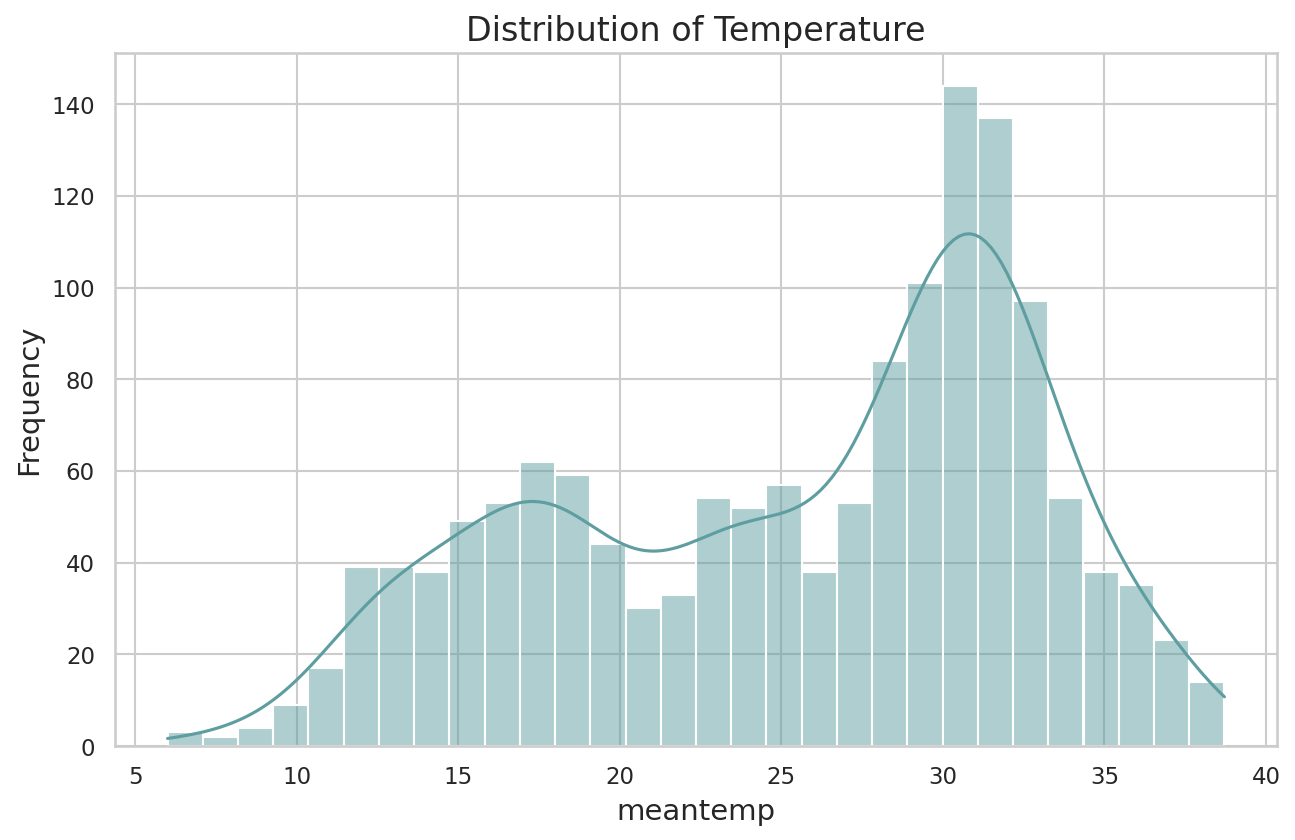

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(train_df['meantemp'], bins=30, kde=True, color='cadetblue')

plt.title('Distribution of Temperature', fontsize=16)
plt.xlabel('meantemp', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

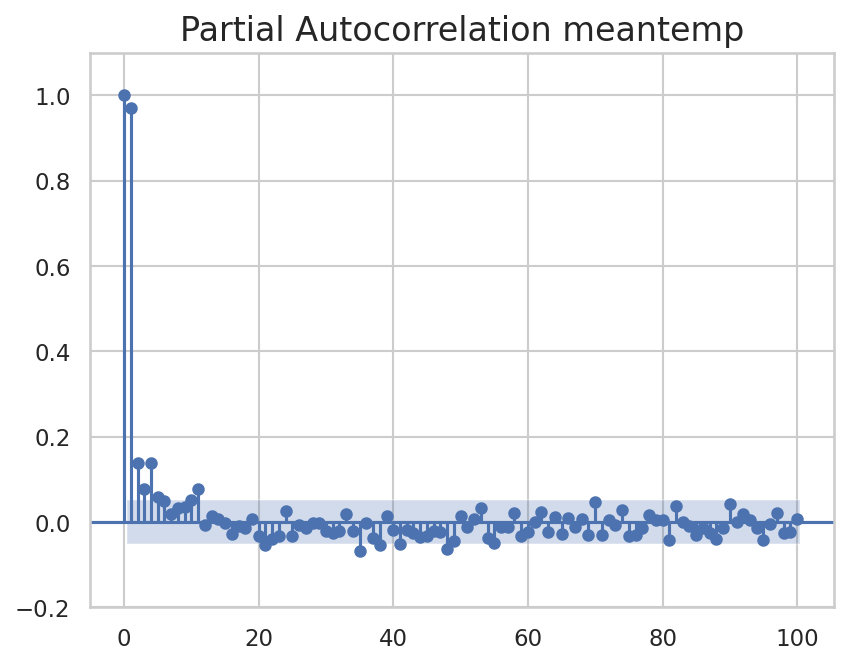

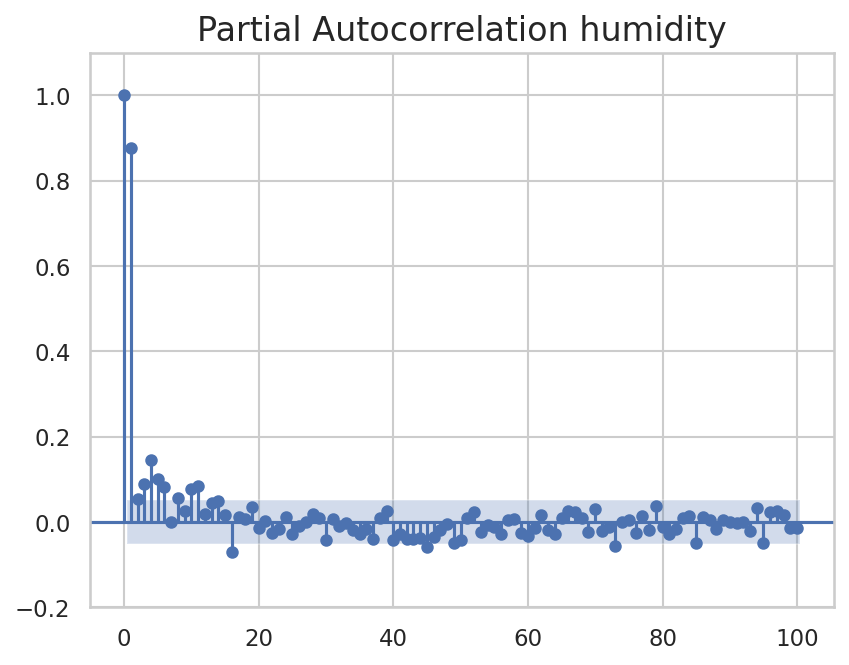

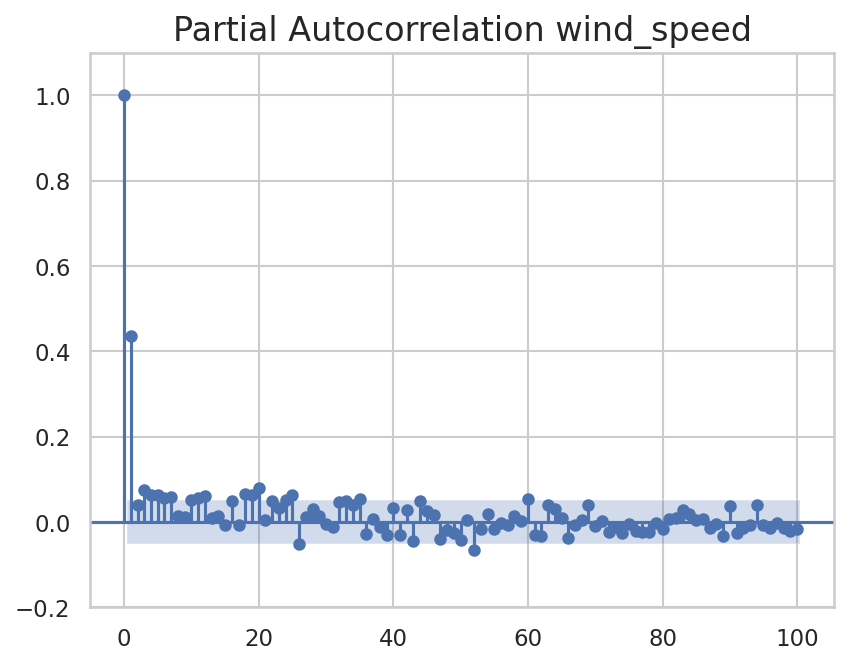

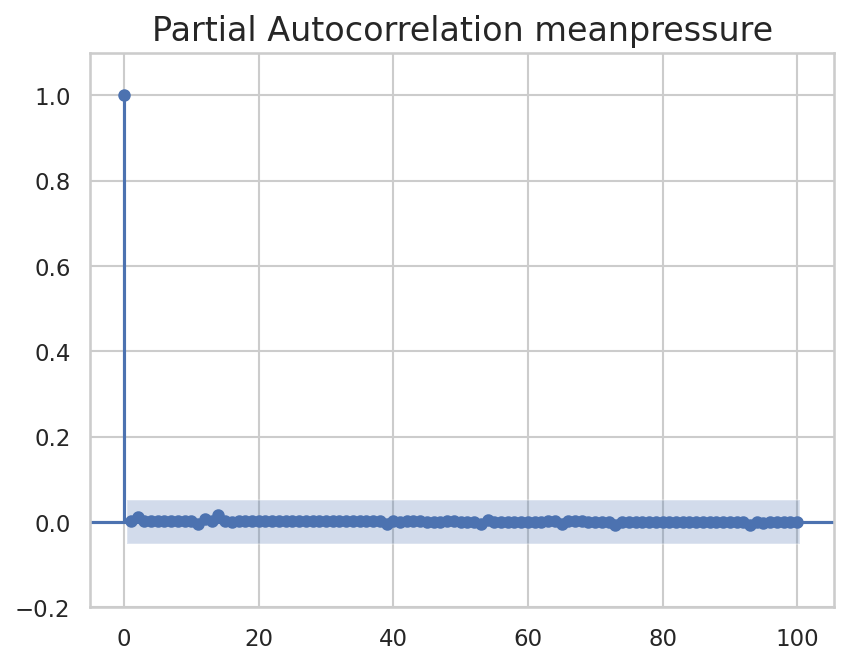

In [ ]:
for i in train_df.drop('date',axis=1).columns:
    plot_pacf(train_df[i], lags=100)
    plt.ylim(-0.2, 1.1)
    plt.tight_layout

    # Adding titles and labels
    plt.title(f'Partial Autocorrelation {i}', fontsize=16)

In [ ]:
for i in train_df.drop('date',axis=1).columns:

    # Calculate the PACF values
    pacf_values = pacf(train_df[i], nlags=100)

    # Determine the confidence interval (typically 95% confidence interval)
    confidence_interval = 1.96 / np.sqrt(len(train_df[i]))

    # Identify significant lags where PACF values exceed the confidence interval
    significant_lags = np.where(np.abs(pacf_values) > confidence_interval)[0]

    print(f'{i} Significant lags: {significant_lags}')

meantemp Significant lags: [ 0  1  2  3  4  5  6 10 11 21 35 38 41 48 55]
humidity Significant lags: [ 0  1  2  3  4  5  6  8 10 11 16 45 49 73 85 95]
wind_speed Significant lags: [ 0  1  3  4  5  6  7 10 11 12 18 19 20 24 25 26 35 52 60]
meanpressure Significant lags: [0]


In [ ]:
def preprocess(df):
    df['year'] = df['date'].dt.year.astype(int)
    df['month'] = df['date'].dt.month.astype(int)
    df['day'] = df['date'].dt.day.astype(int)
    df['week_of_year'] = df['date'].apply(lambda x: x.isocalendar()[1])
    df['day_of_week'] = df['date'].dt.dayofweek.astype(int)

    for i in [1,  2,  3,  4,  5,  6, 10, 11]:
        col_name = f'meantemp | lag {i}'
        df[col_name] = df['meantemp'].shift(i)

    for i in [1,  2,  3 , 4 , 5,  6  ,8, 10, 11]:
        col_name = f'humidity | lag {i}'
        df[col_name] = df['humidity'].shift(i)

    for i in [1,  3,  4,  5,  6,  7, 10, 11]:
        col_name = f'wind_speed | lag {i}'
        df[col_name] = df['wind_speed'].shift(i)


    df['humidity squared'] = df['humidity'] **2
    df['wind_speed squared'] = df['wind_speed'] **2
    df['meanpressure squared'] = df['meanpressure'] **2

    df['humidity root'] = df['humidity'] **0.5
    df['wind_speed root'] = df['wind_speed'] **0.5
    df['meanpressure root'] = df['meanpressure'] **0.5

    df['humidity * wind_speed'] = df['humidity'] * df['wind_speed']
    df['humidity * meanpressure'] = df['humidity'] * df['meanpressure']
    df['meanpressure * wind_speed'] = df['meanpressure'] * df['wind_speed']

    dataframe_date = df.dropna()['date'].copy()
    df = df.drop('date', axis=1)

    return df.dropna(),dataframe_date

In [ ]:
train,_ = preprocess(train_df)
train.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day,week_of_year,day_of_week,meantemp | lag 1,...,wind_speed | lag 11,humidity squared,wind_speed squared,meanpressure squared,humidity root,wind_speed root,meanpressure root,humidity * wind_speed,humidity * meanpressure,meanpressure * wind_speed
11,14.000000,74.000000,13.228571,1015.571429,2013,1,12,2,5,15.714286,...,0.000000,5476.000000,174.995102,1.031385e+06,8.602325,3.637110,31.868031,978.914286,75152.285714,13434.559184
12,15.833333,75.166667,4.633333,1013.333333,2013,1,13,2,6,14.000000,...,2.980000,5650.027778,21.467778,1.026844e+06,8.669871,2.152518,31.832897,348.272222,76168.888889,4695.111111
13,12.833333,88.166667,0.616667,1015.166667,2013,1,14,3,0,15.833333,...,4.633333,7773.361111,0.380278,1.030563e+06,9.389711,0.785281,31.861680,54.369444,89503.861111,626.019444
14,14.714286,71.857143,0.528571,1015.857143,2013,1,15,3,1,12.833333,...,1.233333,5163.448980,0.279388,1.031966e+06,8.476859,0.727029,31.872514,37.981633,72996.591837,536.953061
15,13.833333,86.666667,0.000000,1016.666667,2013,1,16,3,2,14.714286,...,3.700000,7511.111111,0.000000,1.033611e+06,9.309493,0.000000,31.885211,0.000000,88111.111111,0.000000


In [ ]:
test,test_date = preprocess(test_df)
test.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day,week_of_year,day_of_week,meantemp | lag 1,...,wind_speed | lag 11,humidity squared,wind_speed squared,meanpressure squared,humidity root,wind_speed root,meanpressure root,humidity * wind_speed,humidity * meanpressure,meanpressure * wind_speed
11,11.789474,74.578947,6.626316,1016.368421,2017,1,12,2,3,11.000000,...,2.743478,5562.019391,43.908061,1.033005e+06,8.635910,2.574163,31.880534,494.183657,75799.686981,6734.778116
12,13.235294,67.058824,6.435294,1017.529412,2017,1,13,2,4,11.789474,...,2.894444,4496.885813,41.413010,1.035366e+06,8.188945,2.536788,31.898737,431.543253,68234.325260,6548.101038
13,13.200000,74.280000,5.276000,1018.840000,2017,1,14,2,5,13.235294,...,4.016667,5517.518400,27.836176,1.038035e+06,8.618585,2.296955,31.919273,391.901280,75679.435200,5375.399840
14,16.434783,72.565217,3.630435,1018.130435,2017,1,15,2,6,13.200000,...,4.545000,5265.710775,13.180057,1.036590e+06,8.518522,1.905370,31.908156,263.443289,73880.856333,3696.256144
15,14.650000,78.450000,10.380000,1017.150000,2017,1,16,3,0,16.434783,...,3.300000,6154.402500,107.744400,1.034594e+06,8.857200,3.221801,31.892789,814.311000,79795.417500,10558.017000


In [ ]:
pear_corr = train.corr(method='pearson')
pear_corr.style.background_gradient(cmap='OrRd', axis=0)

,meantemp,humidity,wind_speed,meanpressure,year,month,day,week_of_year,day_of_week,meantemp | lag 1,meantemp | lag 2,meantemp | lag 3,meantemp | lag 4,meantemp | lag 5,meantemp | lag 6,meantemp | lag 10,meantemp | lag 11,humidity | lag 1,humidity | lag 2,humidity | lag 3,humidity | lag 4,humidity | lag 5,humidity | lag 6,humidity | lag 8,humidity | lag 10,humidity | lag 11,wind_speed | lag 1,wind_speed | lag 3,wind_speed | lag 4,wind_speed | lag 5,wind_speed | lag 6,wind_speed | lag 7,wind_speed | lag 10,wind_speed | lag 11,humidity squared,wind_speed squared,meanpressure squared,humidity root,wind_speed root,meanpressure root,humidity * wind_speed,humidity * meanpressure,meanpressure * wind_speed
meantemp,1.000000,-0.570838,0.305270,-0.036318,0.082941,0.098641,-0.012935,0.097316,-0.011000,0.973609,0.955568,0.941688,0.934478,0.927994,0.922455,0.901224,0.899768,-0.538695,-0.523682,-0.509890,-0.504136,-0.501466,-0.504074,-0.502329,-0.496243,-0.499352,0.283240,0.291947,0.291873,0.295678,0.311822,0.313688,0.325334,0.325863,-0.560528,0.185637,-0.007717,-0.567867,0.339352,-0.059575,0.054967,-0.520105,0.287241
humidity,-0.570838,1.000000,-0.371495,0.002881,-0.064612,0.085502,0.006568,0.088923,0.033000,-0.526508,-0.500787,-0.480984,-0.469491,-0.459957,-0.450311,-0.414320,-0.413762,0.878981,0.784527,0.719801,0.690744,0.675969,0.666902,0.624771,0.600474,0.605617,-0.315945,-0.255503,-0.226387,-0.213564,-0.234037,-0.219046,-0.198274,-0.189189,0.983919,-0.247442,-0.009181,0.994896,-0.398606,0.019915,0.091736,0.871969,-0.359190
wind_speed,0.305270,-0.371495,1.000000,-0.014156,0.010778,-0.167551,0.013353,-0.168663,-0.051608,0.309647,0.301118,0.283422,0.265729,0.262688,0.257130,0.235559,0.238328,-0.310217,-0.242464,-0.211652,-0.198666,-0.195797,-0.189487,-0.181960,-0.165656,-0.179662,0.434796,0.171885,0.157916,0.156426,0.154430,0.157394,0.121481,0.143336,-0.359638,0.892990,-0.004265,-0.371923,0.959210,-0.024816,0.856207,-0.331253,0.968062
meanpressure,-0.036318,0.002881,-0.014156,1.000000,0.028489,-0.033719,0.036805,-0.030529,-0.031566,-0.035400,-0.041042,-0.020285,-0.025767,-0.034260,-0.037815,-0.033977,-0.034411,0.004052,0.017944,-0.002844,-0.012318,-0.015448,-0.024000,0.008337,0.016326,0.001897,-0.002937,-0.037730,-0.033651,0.008015,0.076662,0.020063,-0.015444,-0.018505,-0.002074,-0.012426,0.984921,0.005736,-0.011963,0.942524,-0.009776,0.490930,0.236282
year,0.082941,-0.064612,0.010778,0.028489,1.000000,-0.020647,-0.012579,-0.005872,0.004758,0.083687,0.083924,0.083503,0.083814,0.083868,0.083270,0.083216,0.082410,-0.065219,-0.066147,-0.066031,-0.067768,-0.068326,-0.067569,-0.068608,-0.069741,-0.067759,0.011315,0.009642,0.008804,0.008249,0.008364,0.012517,0.012164,0.013601,-0.076474,-0.017003,0.034732,-0.056743,0.029453,0.011274,-0.019121,-0.042837,0.017399
month,0.098641,0.085502,-0.167551,-0.033719,-0.020647,1.000000,-0.001074,0.961801,-0.007627,0.112862,0.129412,0.145601,0.162639,0.180122,0.197647,0.269353,0.285875,0.079045,0.071137,0.065850,0.060286,0.052955,0.045699,0.026700,0.002084,-0.008551,-0.165537,-0.159721,-0.155417,-0.153049,-0.150079,-0.161783,-0.138142,-0.133104,0.047490,-0.083049,-0.028108,0.104499,-0.200489,-0.042527,-0.129569,0.056798,-0.171722
day,-0.012935,0.006568,0.013353,0.036805,-0.012579,-0.001074,1.000000,0.047589,0.001350,-0.012882,-0.009124,-0.008419,-0.010630,-0.013939,-0.014251,-0.024069,-0.026833,0.002180,-0.003315,0.003403,0.021270,0.035057,0.040562,0.047137,0.051403,0.056433,0.022430,0.051041,0.038398,0.043325,0.027354,-0.005196,-0.036423,-0.043035,0.005937,0.004635,0.037024,0.006559,0.022337,0.027958,0.014034,0.025499,0.021502
week_of_year,0.097316,0.088923,-0.168663,-0.030529,-0.005872,0.961801,0.047589,1.000000,-0.002574,0.115554,0.133350,0.150188,0.167920,0.184657,0.200943,0.265990,0.281860,0.080594,0.074397,0.066242,0.057869,0.050391,0.041794,0.021664,-0.000167,-0.009965,-0.163929,-0.154046,-0.150682,-0.159911,-0.155481,-0.155167,-0.137638,-0.131106,0.051724,-0.081718,-0.025034,0.107561,-0.205293,-0.0399

In [ ]:
X = train.drop(columns='meantemp')
y = train['meantemp']

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=6,shuffle=False)
X_test = test.drop(columns='meantemp')
y_test = test['meantemp']

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'max_depth': trial.suggest_int('max_depth', 1, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }

    xgb_ = xgb.XGBRegressor(**param)

    # Fit the model on training data
    xgb_.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb_.predict(X_val)

    r2 = r2_score(y_val, y_pred)

    return r2

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params

[I 2025-01-28 05:49:24,487] A new study created in memory with name: no-name-2053c8ed-8709-4afb-a01d-9da3f1cf3fc5
[I 2025-01-28 05:49:27,879] Trial 0 finished with value: 0.9458780855209616 and parameters: {'n_estimators': 562, 'max_depth': 2, 'learning_rate': 0.007199232266077945, 'subsample': 0.7234030209930328, 'colsample_bytree': 0.9808026526471243, 'reg_alpha': 7.445308392740888, 'reg_lambda': 3.544512566931697}. Best is trial 0 with value: 0.9458780855209616.
[I 2025-01-28 05:49:28,067] Trial 1 finished with value: 0.9477588652127681 and parameters: {'n_estimators': 309, 'max_depth': 1, 'learning_rate': 0.02792373959261677, 'subsample': 0.844320841340259, 'colsample_bytree': 0.6032589621605392, 'reg_alpha': 7.7067426438513476, 'reg_lambda': 8.909887958680489}. Best is trial 1 with value: 0.9477588652127681.
[I 2025-01-28 05:49:34,167] Trial 2 finished with value: 0.9582827323774509 and parameters: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.05774290741548644, 'subsam

Best trial:
  Value: 0.9608964204886483
  Params: 
    n_estimators: 490
    max_depth: 2
    learning_rate: 0.04591034407486691
    subsample: 0.6914410015817091
    colsample_bytree: 0.7596363293597143
    reg_alpha: 1.2826587597179302
    reg_lambda: 4.168020219120261


In [ ]:
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_val,y_val)],verbose=0)

# Make predictions on the test set
y_pred_test = xgb_model.predict(X_test)

r2 = r2_score(y_test,y_pred_test)
mse =mean_squared_error(y_test,y_pred_test)
mae = mean_absolute_error(y_test,y_pred_test)

print("Test MAE:",mae )
print("Test MSE:",mse )
print("Test R2:",r2 )

Test MAE: 1.1938717070946088
Test MSE: 2.367858406100982
Test R2: 0.9404883739150242


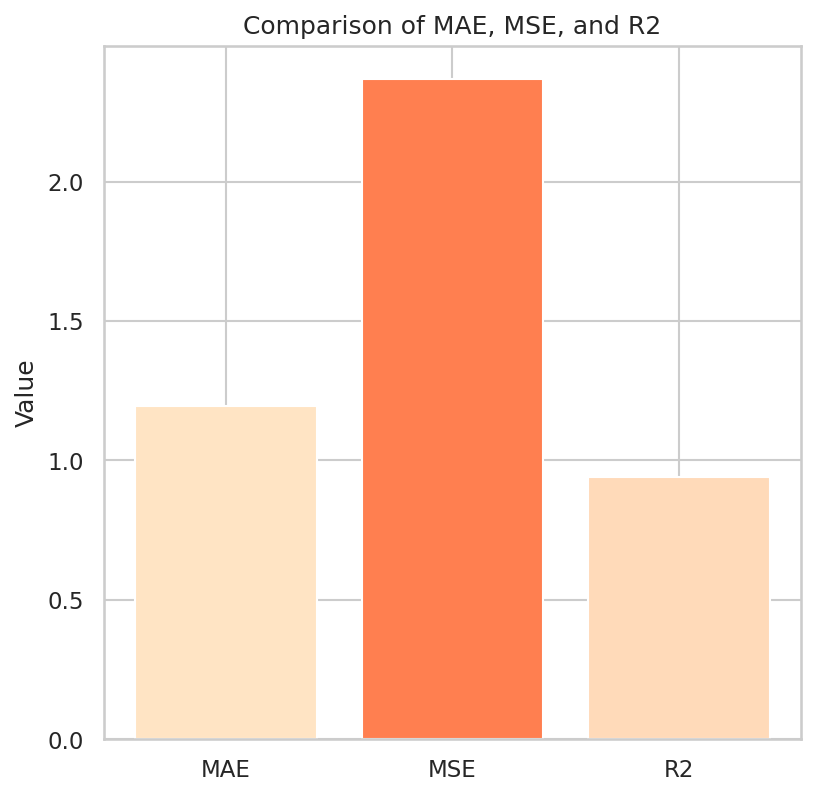

Test MAE: 1.1938717070946088
Test MSE: 2.367858406100982
Test R2: 0.9404883739150242


In [ ]:
metrics = ['MAE', 'MSE', 'R2']
values = [mae, mse, r2]
plt.figure(figsize=(6, 6))
plt.bar(metrics, values, color=['bisque', 'coral', 'peachpuff'])
plt.title('Comparison of MAE, MSE, and R2')
plt.ylabel('Value')
plt.show()

# Print the values for each metric
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test R2:", r2)

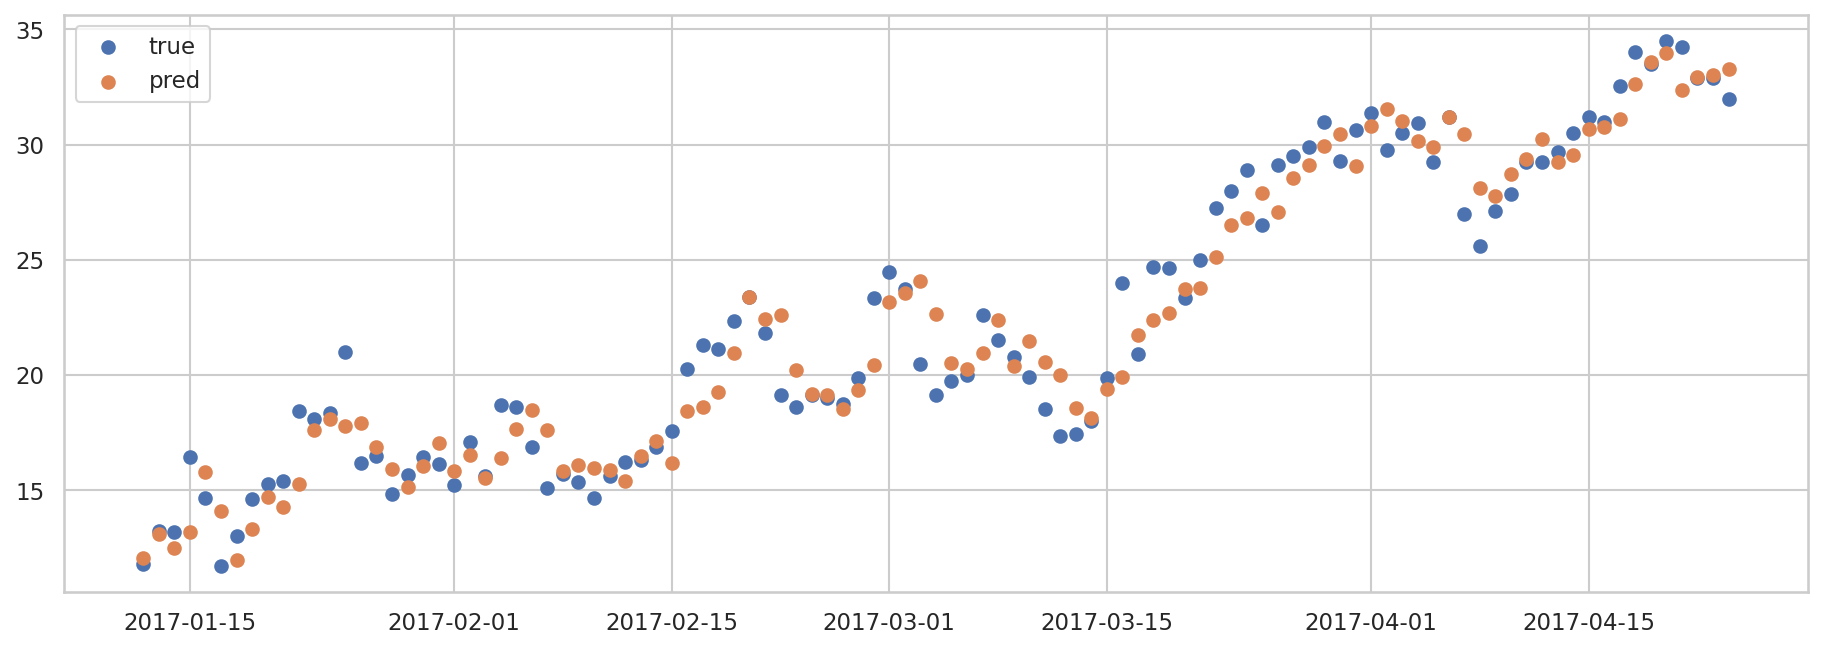

In [ ]:
plt.figure(figsize=(15,5))

plt.scatter(test_date,y_test,label='true')
plt.scatter(test_date,y_pred_test,label='pred')
plt.legend()
plt.show()

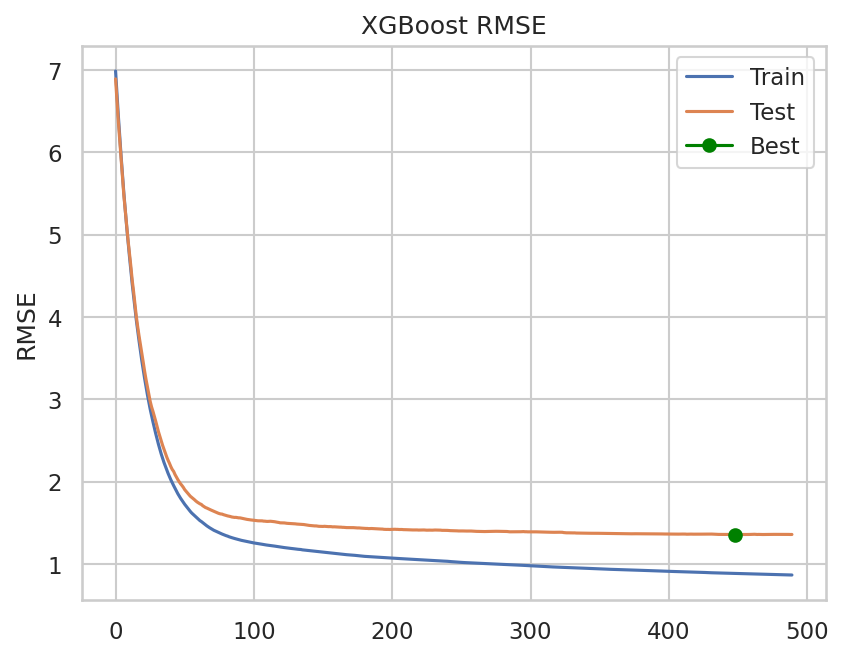

In [ ]:
results = xgb_model.evals_result()
val_rmse = results["validation_1"]['rmse']
best_epopch = min(val_rmse)
i_best_epoch = val_rmse.index(best_epopch)
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot m log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()


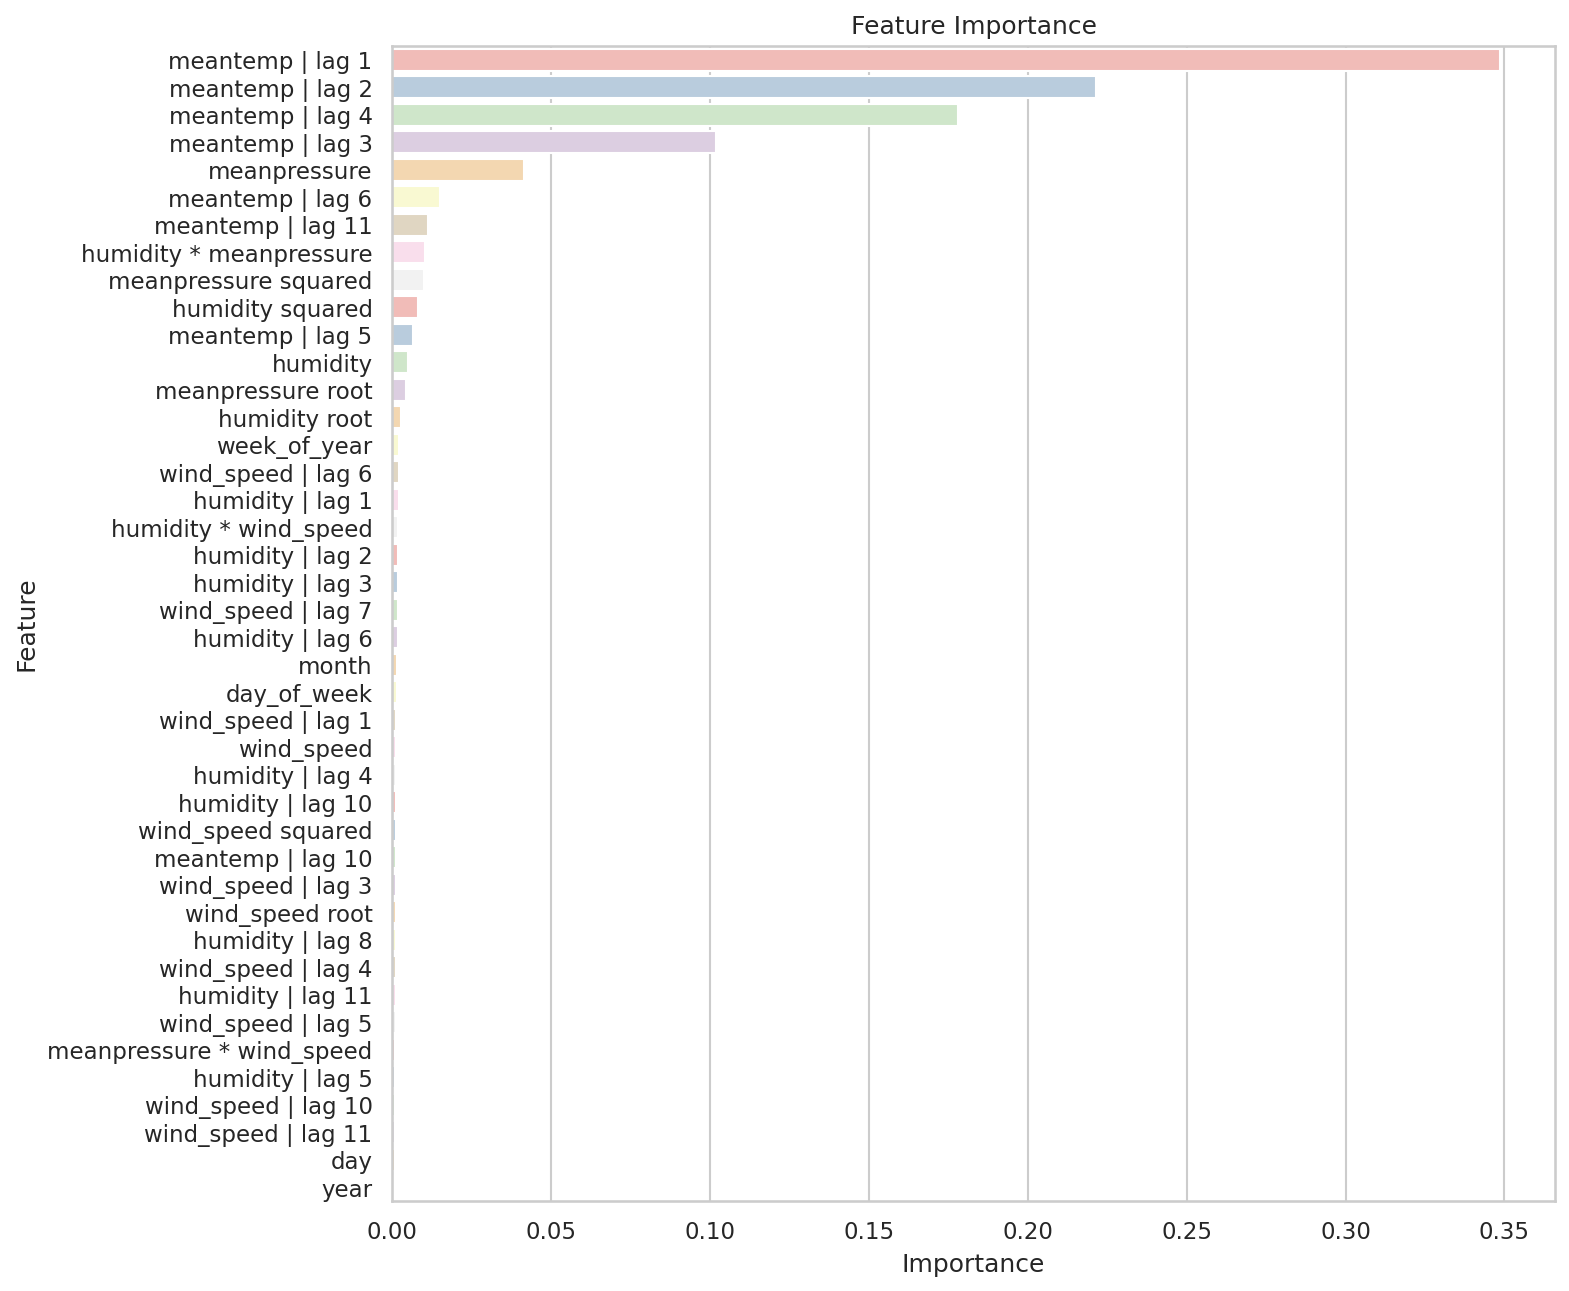

In [ ]:
# Optianing the most features that had an impact of our price
def plot_feature_importance(model, feature_names=None, plot=True):

    feature_importance = model.feature_importances_

    if feature_names is None:
        feature_names = model.feature_name()

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Pastel1')
        plt.title('Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_feature_importance(xgb_model,feature_names=X_train.columns)

Test MAE: 1.1938717070946088
Test MSE: 2.367858406100982
Test R2: 0.9404883739150242


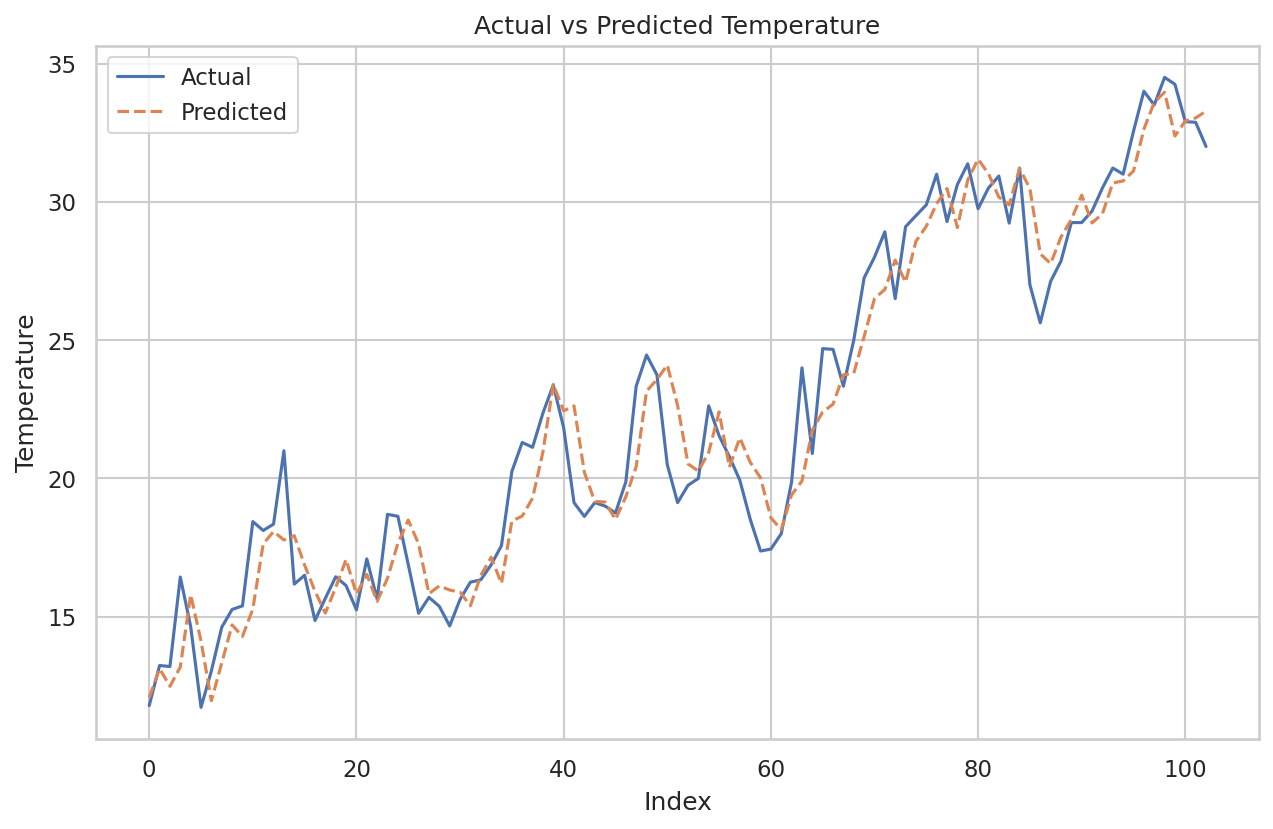

In [ ]:
# Prediksi pada data uji
y_pred_test = xgb_model.predict(X_test)

# Hitung metrik evaluasi
r2 = r2_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

# Tampilkan hasil evaluasi
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test R2:", r2)

# Plot hasil prediksi vs nilai aktual
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
results = pd.DataFrame({
    'Actual Temperature': y_test,
    'Predicted Temperature': y_pred_test
})
results.to_csv('weather_predictions.csv', index=False)
print("Feature importance saved to 'weather_predictions.csv'")

Feature importance saved to 'weather_predictions.csv'


In [ ]:
study_df = pd.DataFrame(study.trials_dataframe())
study_df.to_csv('hyperparameter_tuning.csv', index=False)

In [ ]:
metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R2'],
    'Value': [mae, mse, r2]
})
metrics.to_csv('model_metrics.csv', index=False)